In [12]:
import pandas as pd
import argparse
import random
import time
import os
import duckdb
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.cluster import KMeans
%matplotlib inline
import sys
sys.path.append(os.path.abspath(os.getcwd()+'/..'))

from config_loc import get_data_db_folder
from featurelib.lib_v1 import *
from kmeans_manual import get_pivoted_data

plt.style.use('ggplot')


g_folder = 'res_exploration_v1'

In [9]:
pdf = get_pivoted_data()
pdf.index=pd.to_datetime(pdf.index*1e3)


Reading data from DuckDB


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Cleaning data
Stepper creating instance res_kmeans_v1 None_close_diff1
Stepper creating instance res_kmeans_v1 None_tret_clip
Stepper creating instance res_kmeans_v1 None_volume_ewm1000
Stepper creating instance res_kmeans_v1 None_tret


In [23]:
def analyze_pair(pdf,t1='BTCUSDT',t2='ETHUSDT'):
    corr = pdf[[t1,t2]].corr()
    plt.figure()
    pdf[[t1,t2]].fillna(0.0).cumsum().plot()
    plt.figure()
    sns.regplot(data=pdf[[t1,t2]].fillna(0.0),x=t1,y=t2)
    print(f'Correl of {corr}')

Correl of           BTCUSDT   ETHUSDT
BTCUSDT  1.000000  0.739501
ETHUSDT  0.739501  1.000000


<Figure size 640x480 with 0 Axes>

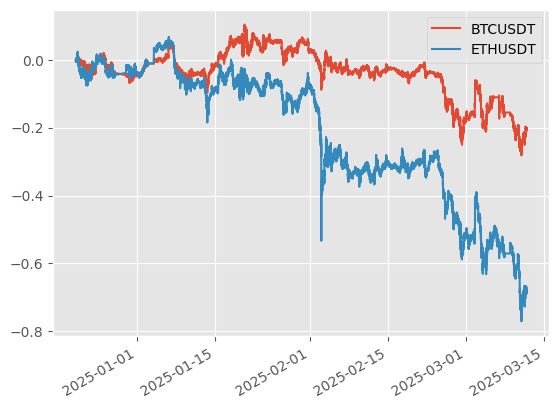

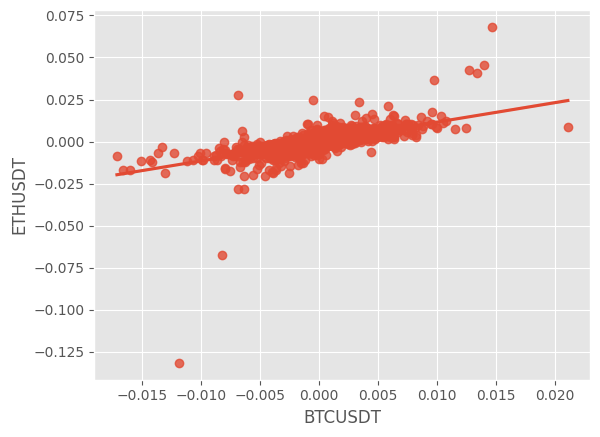

In [29]:
analyze_pair(pdf,t1='BTCUSDT',t2='ETHUSDT')

Correl of            COMBOUSDT   ETHUSDT
COMBOUSDT   1.000000  0.642116
ETHUSDT     0.642116  1.000000


<Figure size 640x480 with 0 Axes>

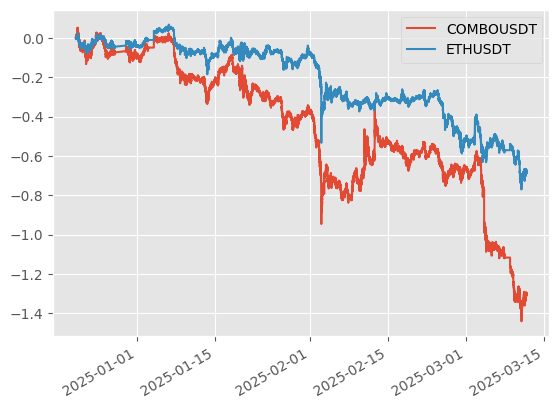

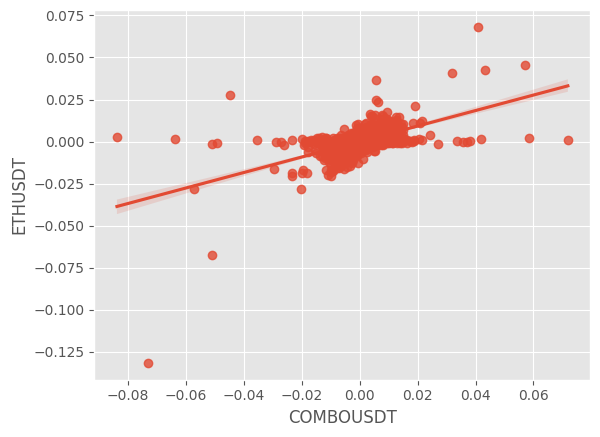

In [28]:
analyze_pair(pdf,t1='COMBOUSDT',t2='ETHUSDT')

Correl of           VVVUSDT   ETHUSDT
VVVUSDT  1.000000  0.354786
ETHUSDT  0.354786  1.000000


<Figure size 640x480 with 0 Axes>

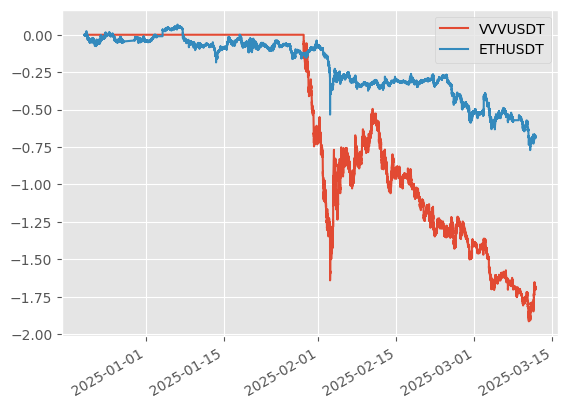

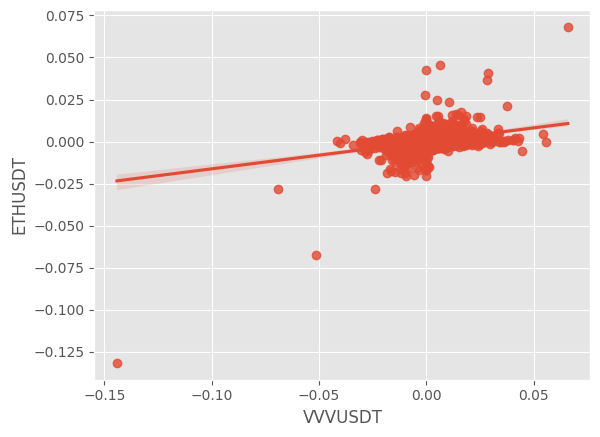

In [25]:
analyze_pair(pdf,t1='VVVUSDT',t2='ETHUSDT')


Correl of           ARBUSDT   ETHUSDT
ARBUSDT  1.000000  0.858308
ETHUSDT  0.858308  1.000000


<Figure size 640x480 with 0 Axes>

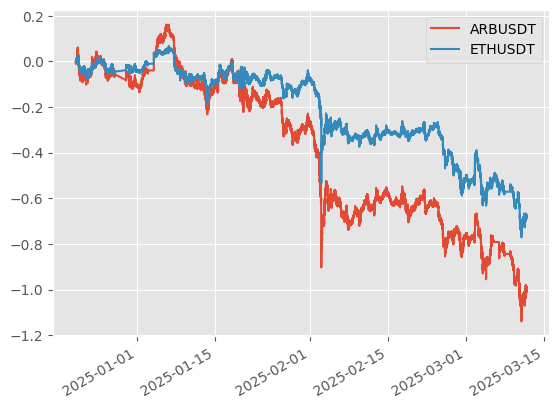

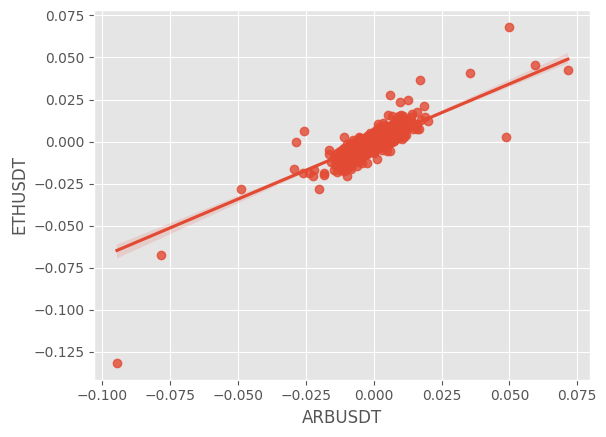

In [26]:
analyze_pair(pdf,t1='ARBUSDT',t2='ETHUSDT')


Correl of           DEGOUSDT  ETHUSDT
DEGOUSDT   1.00000  0.54251
ETHUSDT    0.54251  1.00000


<Figure size 640x480 with 0 Axes>

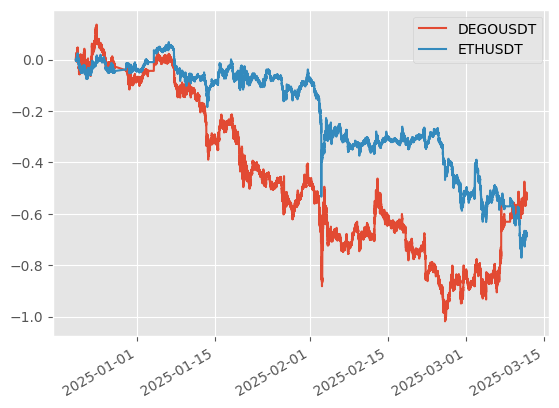

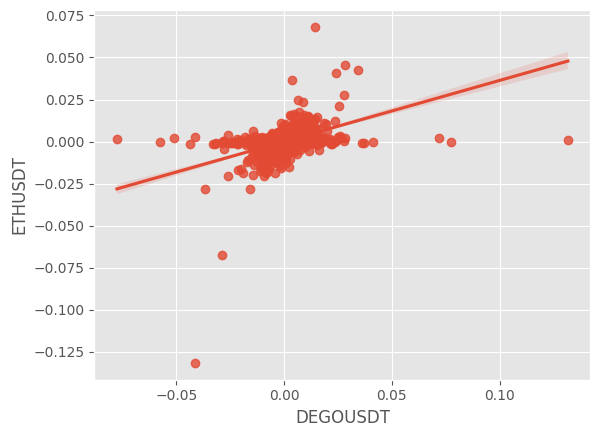

In [27]:
analyze_pair(pdf,t1='DEGOUSDT',t2='ETHUSDT')


Correl of           BNBUSDT   ETHUSDT
BNBUSDT  1.000000  0.764415
ETHUSDT  0.764415  1.000000


<Figure size 640x480 with 0 Axes>

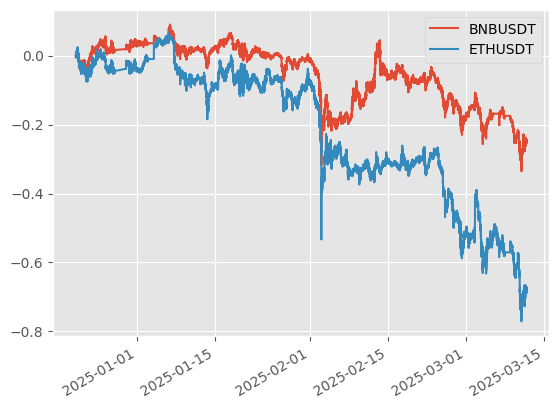

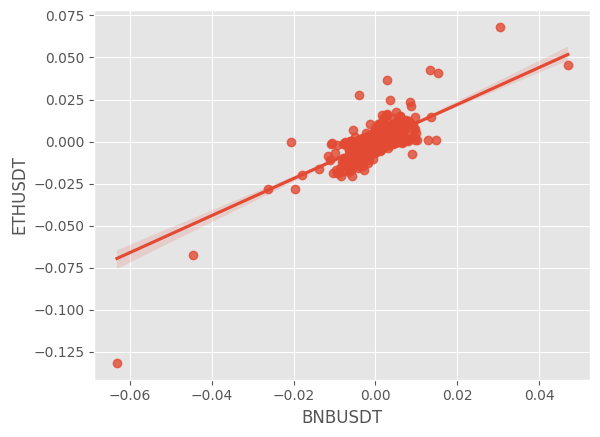

In [30]:
analyze_pair(pdf,t1='BNBUSDT',t2='ETHUSDT')